In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from patchify import patchify

In [ ]:
# Constants
PATCH_SIZE = 256
DATASET_DIR = "client_data"
OUTPUT_DIR = "dataset_patched_final"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
# Function to detect and crop Petri dishes

def detect_and_crop_petri_dish_with_masks(image_path, mask_paths):
    image = cv2.imread(image_path, 0)  # Grayscale image
    original_image = cv2.imread(image_path)  # Original image for cropping

    blurred = cv2.medianBlur(image, 5)
    _, output_im = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY)

    kernel = np.ones((9, 9), np.uint8)
    im_d = cv2.dilate(output_im, kernel, iterations=3)
    im_closing = cv2.erode(im_d, kernel, iterations=4)

    contours, _ = cv2.findContours(im_closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return None, []

    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)

    size = max(w, h)
    x_center, y_center = x + w // 2, y + h // 2
    x_start, y_start = x_center - size // 2, y_center - size // 2
    x_end, y_end = x_start + size, y_start + size

    cropped_image = original_image[max(0, y_start):min(image.shape[0], y_end), 
                                   max(0, x_start):min(image.shape[1], x_end)]

    cropped_masks = []
    for mask_path in mask_paths:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        cropped_mask = mask[max(0, y_start):min(mask.shape[0], y_end), 
                            max(0, x_start):min(mask.shape[1], x_end)]
        cropped_masks.append(cropped_mask)

    return cropped_image, cropped_masks

In [ ]:
# Function to create patches and save them
def create_patches_and_save(image_dir, mask_dir, output_dir, patch_size, dataset_type):
    os.makedirs(os.path.join(output_dir, f"{dataset_type}_images/{dataset_type}"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, f"{dataset_type}_masks/{dataset_type}"), exist_ok=True)

    for image_name in tqdm(os.listdir(image_dir)):
        if not image_name.endswith(".png"):
            continue

        if dataset_type == "val" and not image_name.startswith("val_"):
            continue

        if dataset_type == "train" and image_name.startswith("val_"):
            continue

        image_path = os.path.join(image_dir, image_name)
        base_name = image_name[:-4]

        mask_paths = []
        if "Y2B_23" in mask_dir:
            mask_path = os.path.join(mask_dir, f"{base_name}_root_mask.tif")
            if os.path.exists(mask_path):
                mask_paths.append(mask_path)
        elif "Y2B_24" in mask_dir:
            for teacher_folder in os.listdir(mask_dir):
                teacher_folder_path = os.path.join(mask_dir, teacher_folder)
                if os.path.isdir(teacher_folder_path):
                    mask_path = os.path.join(teacher_folder_path, f"{base_name}_root_mask.tif")
                    if os.path.exists(mask_path):
                        mask_paths.append(mask_path)

        mask_paths = [path for path in mask_paths if os.path.exists(path)]

        if not mask_paths:
            continue

        cropped_image, cropped_masks = detect_and_crop_petri_dish_with_masks(image_path, mask_paths)

        if cropped_image is None or not cropped_masks:
            continue

        height, width = cropped_image.shape[:2]
        pad_h = (patch_size - height % patch_size) % patch_size
        pad_w = (patch_size - width % patch_size) % patch_size

        padded_image = np.pad(cropped_image, ((0, pad_h), (0, pad_w), (0, 0)), mode='constant')
        padded_masks = [
            np.pad(mask, ((0, pad_h), (0, pad_w)), mode='constant') for mask in cropped_masks
        ]

        image_patches = patchify(padded_image, (patch_size, patch_size, 3), step=patch_size)
        mask_patches = [patchify(mask, (patch_size, patch_size), step=patch_size) for mask in padded_masks]

        for i in range(image_patches.shape[0]):
            for j in range(image_patches.shape[1]):
                image_patch = image_patches[i, j, 0]
                combined_mask_patch = np.zeros((patch_size, patch_size), dtype=np.uint8)

                for mask_patch in mask_patches:
                    combined_mask_patch = cv2.bitwise_or(combined_mask_patch, mask_patch[i, j])

                combined_mask_patch = (combined_mask_patch * 255).astype(np.uint8)

                patch_name = f"{base_name}_{i}_{j}.png"

                cv2.imwrite(
                    os.path.join(output_dir, f"{dataset_type}_images/{dataset_type}", patch_name), image_patch
                )
                cv2.imwrite(
                    os.path.join(output_dir, f"{dataset_type}_masks/{dataset_type}", patch_name), combined_mask_patch
                )

In [4]:
# Processing datasets
DATASET_Y2B23 = os.path.join(DATASET_DIR, "Y2B_23")
DATASET_Y2B24 = os.path.join(DATASET_DIR, "Y2B_24")

create_patches_and_save(
    os.path.join(DATASET_Y2B23, "images/train"),
    os.path.join(DATASET_Y2B23, "masks"),
    OUTPUT_DIR, PATCH_SIZE, "train"
)

create_patches_and_save(
    os.path.join(DATASET_Y2B24, "images"),
    os.path.join(DATASET_Y2B24, "masks"),
    OUTPUT_DIR, PATCH_SIZE, "train"
)

create_patches_and_save(
    os.path.join(DATASET_Y2B24, "images"),
    os.path.join(DATASET_Y2B24, "masks"),
    OUTPUT_DIR, PATCH_SIZE, "val"
)

100%|██████████| 450/450 [00:52<00:00,  8.57it/s]


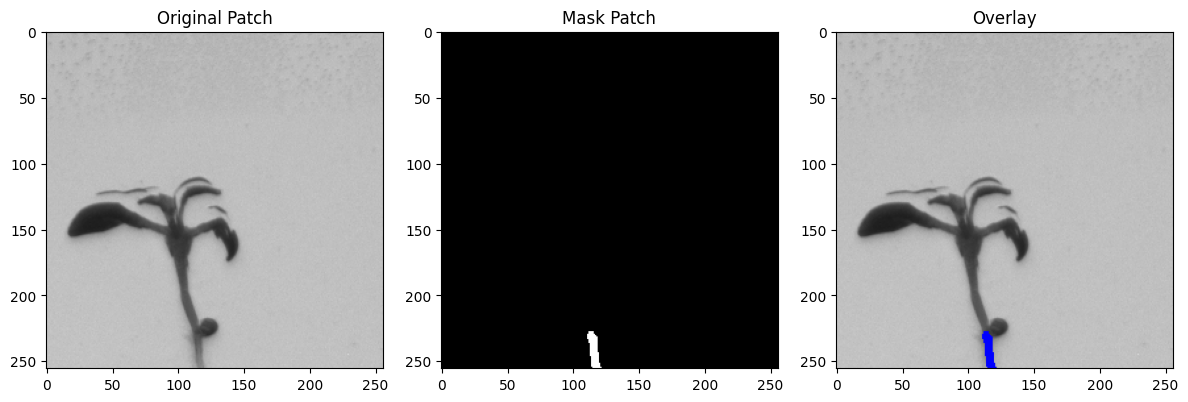

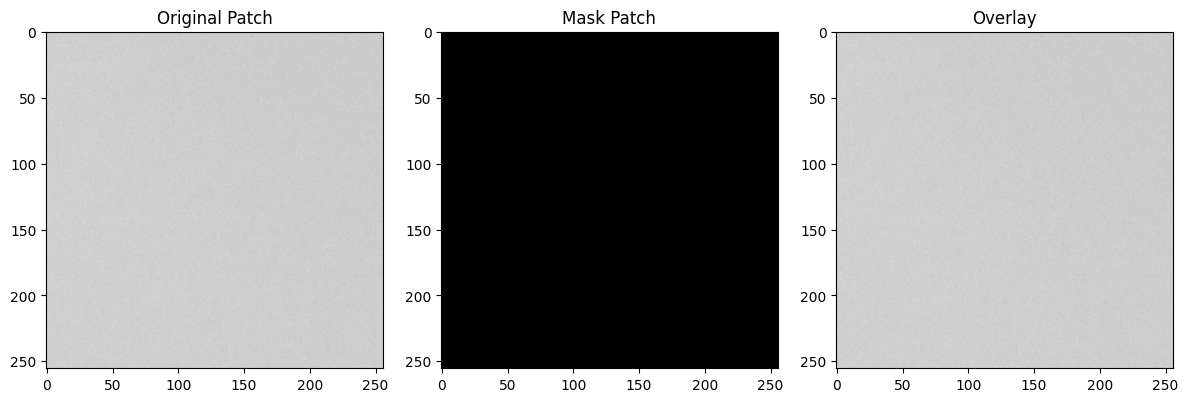

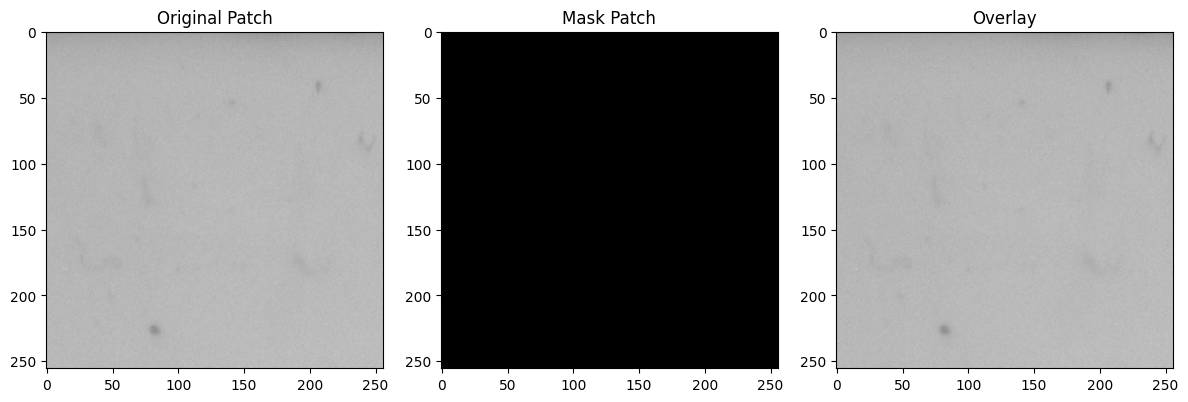

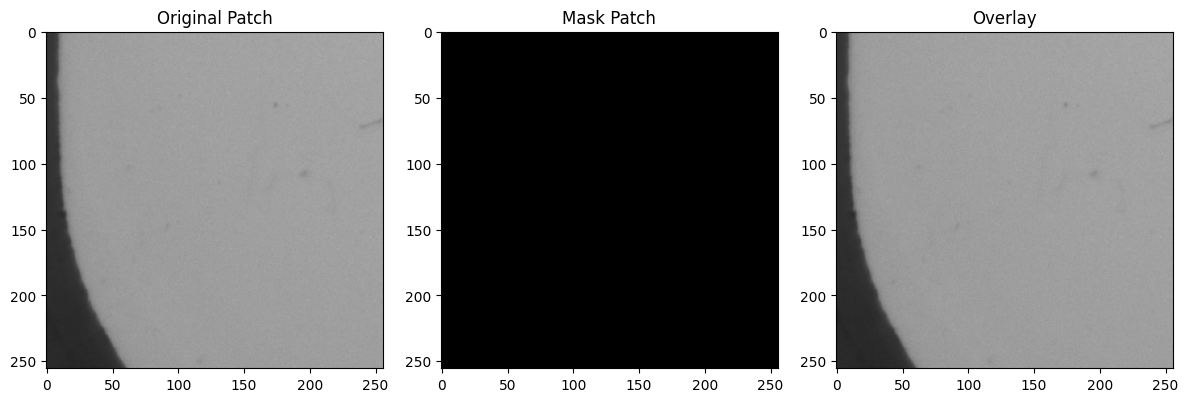

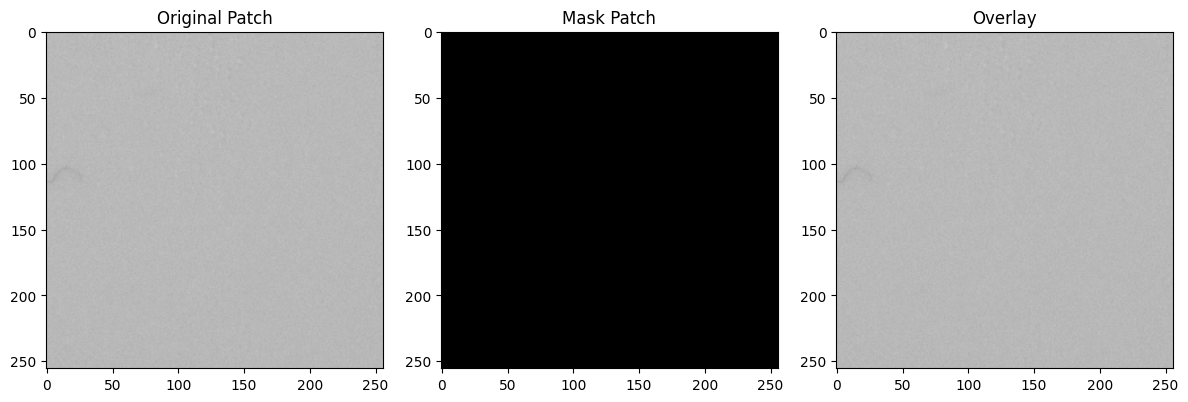

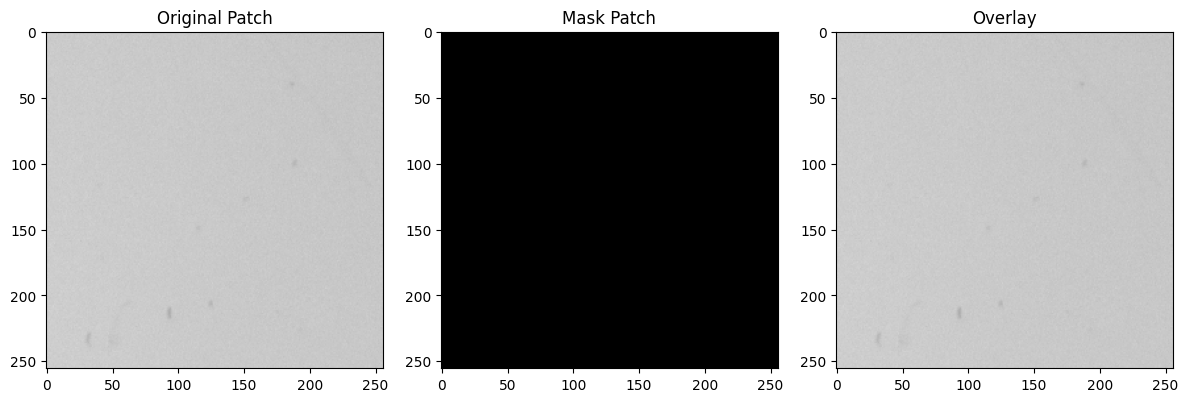

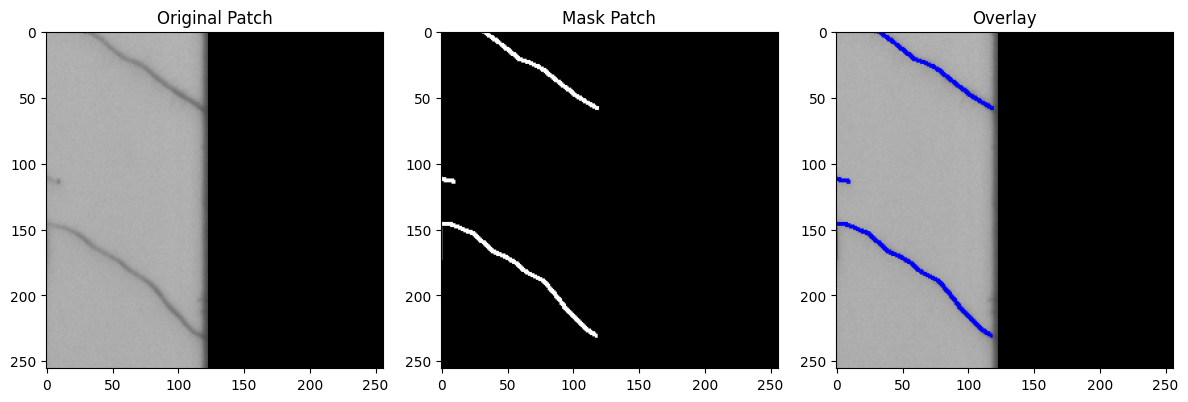

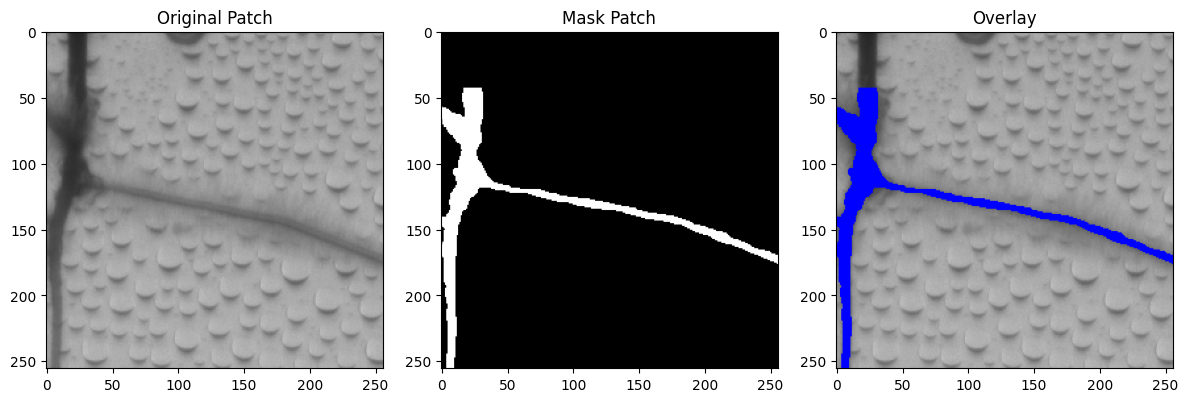

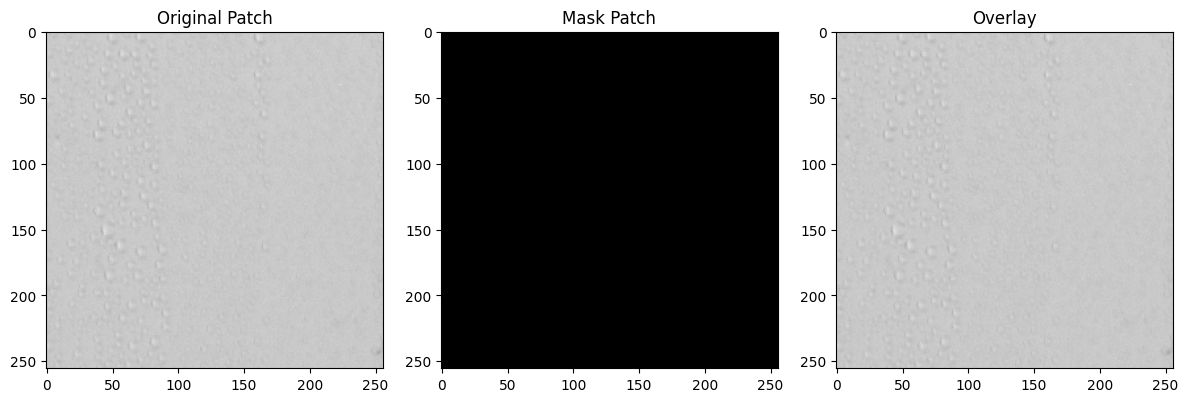

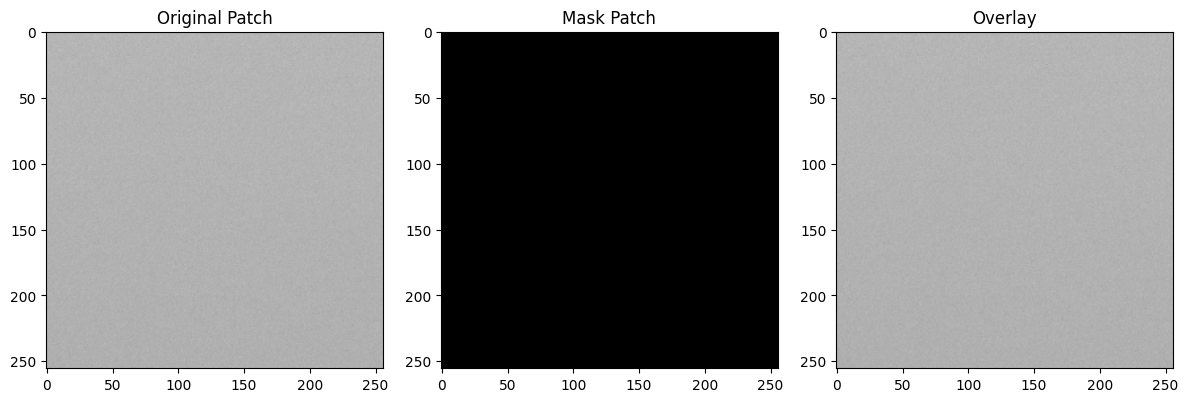

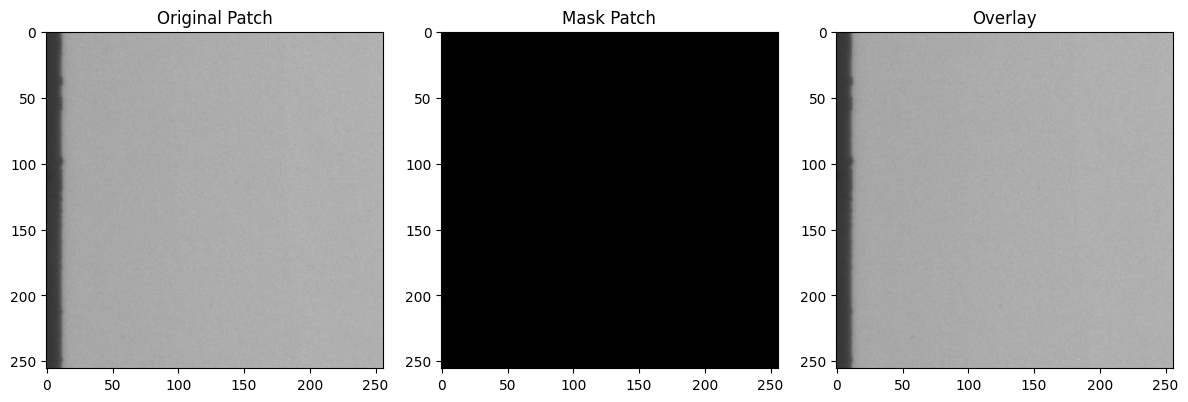

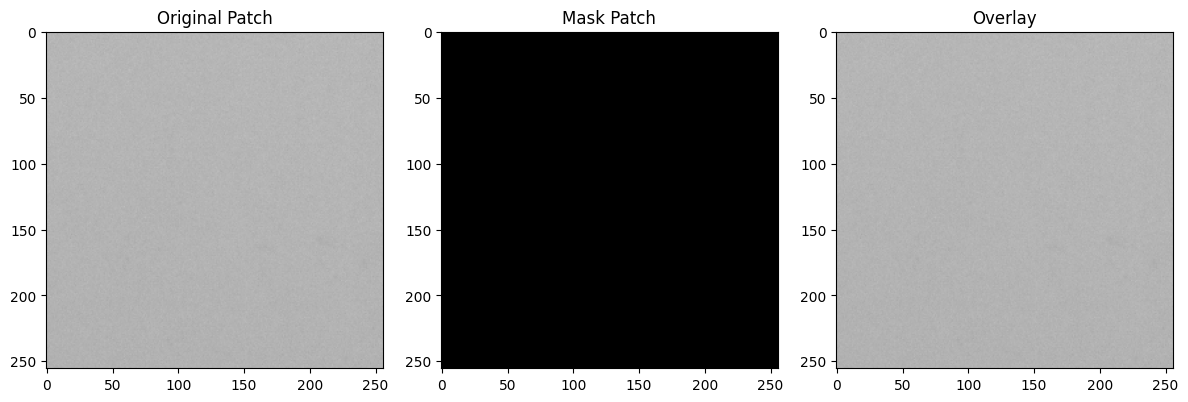

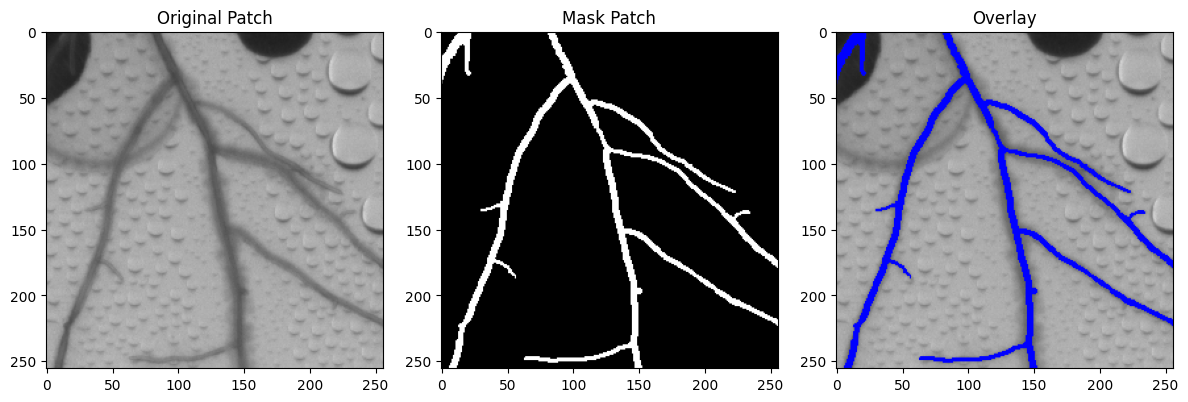

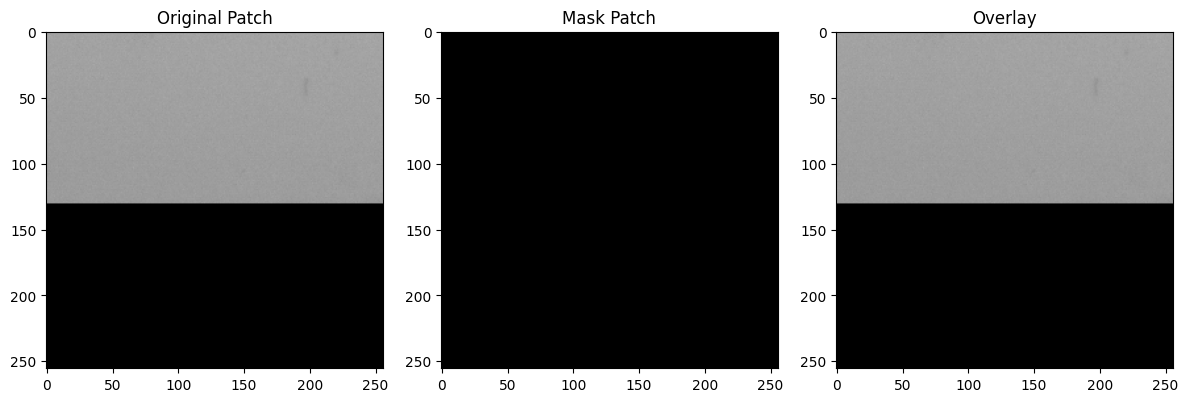

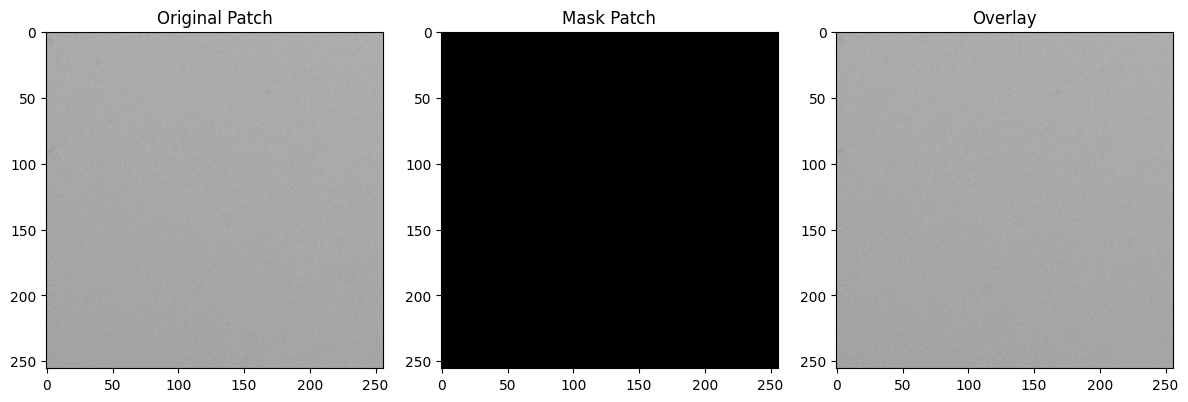

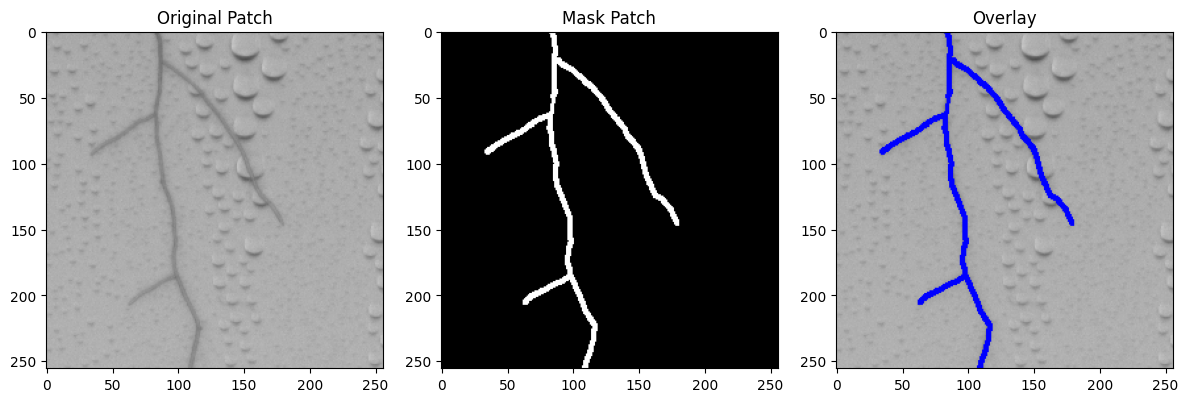

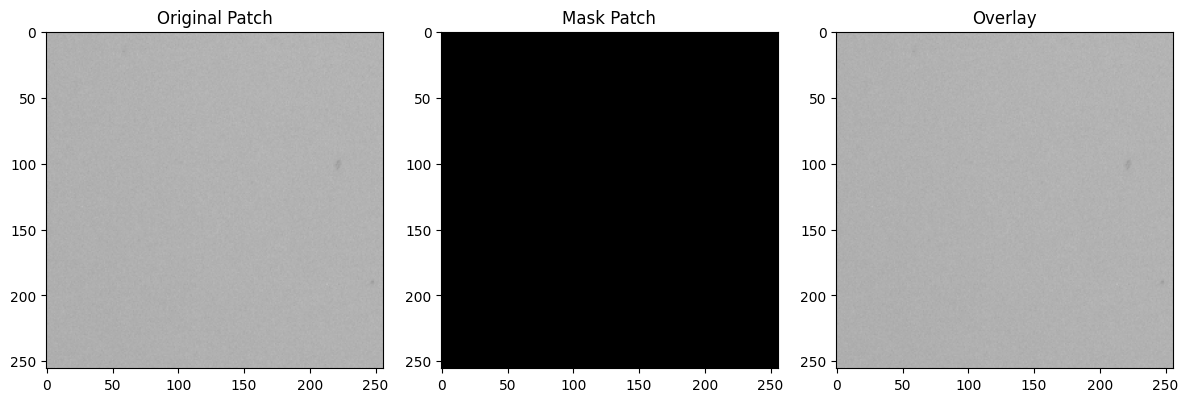

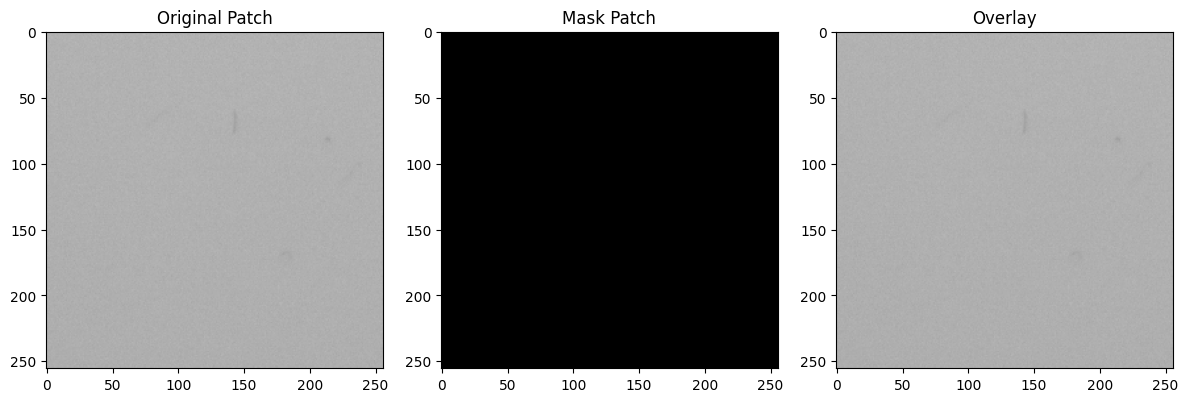

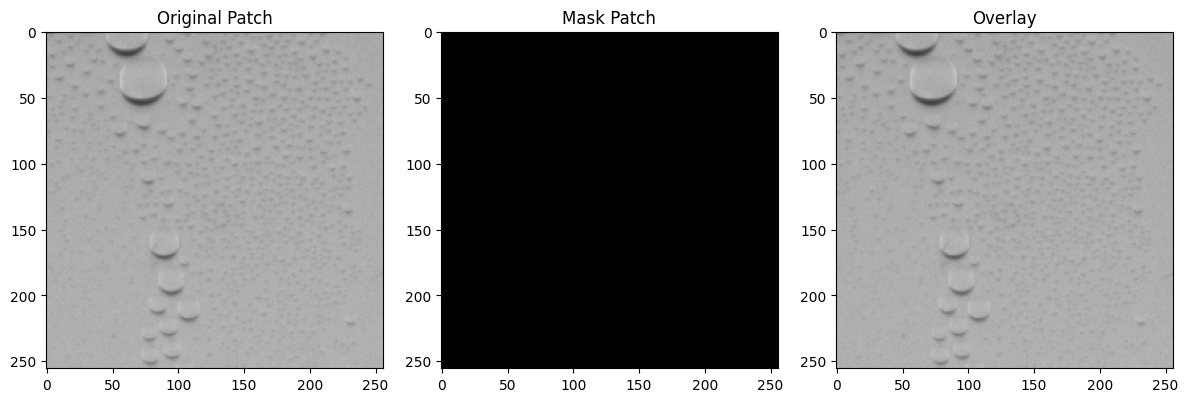

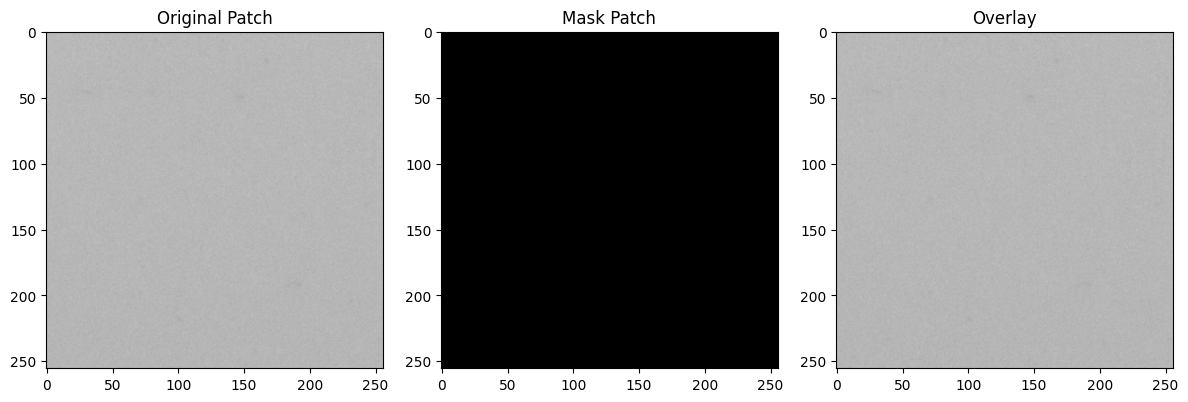

In [7]:
# Display random patches
def display_random_patches(output_dir, dataset_type="train"):
    image_dir = os.path.join(output_dir, f"{dataset_type}_images/{dataset_type}")
    mask_dir = os.path.join(output_dir, f"{dataset_type}_masks/{dataset_type}")

    for _ in range(10):
        random_image_name = np.random.choice(os.listdir(image_dir))
        image_path = os.path.join(image_dir, random_image_name)
        mask_path = os.path.join(mask_dir, random_image_name)

        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Overlay
        overlay = image.copy()
        overlay[mask > 0] = [255, 0, 0]  # Red mask

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        axes[0].set_title("Original Patch")
        axes[1].imshow(mask, cmap="gray")
        axes[1].set_title("Mask Patch")
        axes[2].imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
        axes[2].set_title("Overlay")
        plt.tight_layout()
        plt.show()

display_random_patches(OUTPUT_DIR, "train")
display_random_patches(OUTPUT_DIR, "val")